In [ ]:
!pip install tweet-preprocessor
!pip install demoji

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
import preprocessor as p
import demoji
demoji.download_codes()

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
from google.colab import drive

import seaborn as sns

#Loading CVS file
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
... OK (Got response in 0.12 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [ ]:
#Cesar's
twitter = pd.read_csv("/content/drive/My Drive/DS4A/Project/OFFCORSS_Tweets/Combined_tweets/Combined_tweets.csv")

#Manu's
#twitter = pd.read_csv("/content/drive/My Drive/Combined_tweets/Combined_tweets.csv")

twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2643 entries, 0 to 2642
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Usuario         2643 non-null   object 
 1   Fecha Creacion  2643 non-null   object 
 2   Tweet           2643 non-null   object 
 3   Sentimiento     2634 non-null   object 
 4   UrlenTweet      620 non-null    object 
 5   UrlTweet        2643 non-null   object 
 6   Positivos       30 non-null     float64
 7   Negativos       30 non-null     float64
 8   Neutros         30 non-null     float64
dtypes: float64(3), object(6)
memory usage: 186.0+ KB


In [ ]:
STOPWORDS=set(stopwords.words('spanish'))
STOPWORDS.add('https')
STOPWORDS.add('fds')
STOPWORDS.add('sr')
STOPWORDS.add('rt')
STOPWORDS.add('gt')
STOPWORDS.add('co')
STEMMER = SnowballStemmer('spanish')
non_words = list(punctuation)
non_words.extend(['¿', '¡'])

# Urls, Hashtags, Mentions and Emojis

In [ ]:
parsed_tweets = twitter['Tweet'].apply(lambda x: p.parse(x)).tolist()
urls_found = [parsed_tweet.urls for parsed_tweet in parsed_tweets]
hashtags_found = [parsed_tweet.hashtags for parsed_tweet in parsed_tweets]
mentions_found = [parsed_tweet.mentions for parsed_tweet in parsed_tweets]
emojis_found = [parsed_tweet.emojis for parsed_tweet in parsed_tweets]

In [ ]:
parsed_urls = []
for i in range(len(urls_found)):
    if urls_found[i]:
        parsed_urls.append([])
        for url_found in urls_found[i]:
            parsed_urls[i].append(url_found.match) 
        parsed_urls[i] = ' '.join(parsed_urls[i])
    else:
        parsed_urls.append(None)

parsed_hashtags = []
for i in range(len(hashtags_found)):
    if hashtags_found[i]:
        parsed_hashtags.append([])
        for hashtag_found in hashtags_found[i]:
            parsed_hashtags[i].append(hashtag_found.match) 
        parsed_hashtags[i] = ' '.join(parsed_hashtags[i])
    else:
        parsed_hashtags.append(None)
        
parsed_mentions = []
for i in range(len(mentions_found)):
    if mentions_found[i]:
        parsed_mentions.append([])
        for mention_found in mentions_found[i]:
            parsed_mentions[i].append(mention_found.match) 
        parsed_mentions[i] = ' '.join(parsed_mentions[i])
    else:
        parsed_mentions.append(None)
        
parsed_emojis = []
for i in range(len(emojis_found)):
    if emojis_found[i]:
        parsed_emojis.append([])
        for emoji_found in emojis_found[i]:
            parsed_emojis[i].append(emoji_found.match) 
        parsed_emojis[i] = ' '.join(parsed_emojis[i])
    else:
        parsed_emojis.append(None)

In [ ]:
twitter = twitter.drop(columns =['UrlenTweet'])
twitter['urls_in_tweet'] = parsed_urls
twitter['hashtags_in_tweet'] = parsed_hashtags
twitter['mentions_in_tweet'] = parsed_mentions
twitter['emojis_in_tweet'] = parsed_emojis

In [ ]:
twitter['emojis_in_tweet'][0]

'🐨 ✨ ➤'

In [ ]:
def preprocess(tweet):
    tweet = tweet.str.replace('á','a')
    tweet = tweet.str.replace('é', 'e')
    tweet = tweet.str.replace('í', 'i')
    tweet = tweet.str.replace('ó', 'o')
    tweet = tweet.str.replace('ú', 'u')
    tweet = tweet.str.replace('ñ', 'n') 
    tweet = tweet.str.replace('\n', '') 
    tweet = tweet.str.replace('[/(){}\[\]\|,;]', ' ') 
    tweet = tweet.str.lower()
    return tweet

twitter['cleaned_tweet'] = preprocess(twitter['Tweet'])
twitter['Fecha Creacion'] = pd.to_datetime(twitter['Fecha Creacion'], format='%b %d %Y %I:%M %p')

twitter.head()

,Usuario,Fecha Creacion,Tweet,Sentimiento,UrlTweet,Positivos,Negativos,Neutros,urls_in_twwet,hashtags_in_tweet,mentions_in_tweet,emojis_in_tweet,cleaned_tweet
0,OFFCORSS,2020-08-11 14:00:00,"OFFCORSS Newborn, nuestra propuesta para bebés...",positive,https://twitter.com/OFFCORSS/status/1293185402...,26.0,2.0,19.0,https://t.co/BkBxOWghyj https://t.co/dlMUuDHXsD,#OFFCORSSNewborn #OFFCORSS,None,🐨 ✨ ➤,offcorss newborn nuestra propuesta para bebes...
1,maria🇨🇴,2020-08-11 12:11:00,Todos escogimos offcorss o que?,neutral,https://twitter.com/Icanbefreedom/status/12931...,NaN,NaN,NaN,None,None,None,None,todos escogimos offcorss o que?
2,☆ Jessica Ospina ☆,2020-08-11 03:02:00,"RT @OFFCORSS: Estamos muy felices, nuestra mar...",positive,https://twitter.com/Jom221/status/129301989039...,NaN,NaN,NaN,None,None,@OFFCORSS,None,rt @offcorss: estamos muy felices nuestra mar...
3,Carlos Alberto Peña,2020-08-11 01:27:00,"RT @OFFCORSS: Estamos muy felices, nuestra mar...",positive,https://twitter.com/cap2004_1/status/129299601...,NaN,NaN,NaN,None,None,@OFFCORSS,None,rt @offcorss: estamos muy felices nuestra mar...
4,OFFCORSS,2020-08-10 17:00:00,"Estamos muy felices, nuestra marca llegó a Per...",positive,https://twitter.com/OFFCORSS/status/1292868311...,NaN,NaN,NaN,https://t.co/bRx2PeNRYS,#OFFCORSSPerú #OFFCORSS #ItsCoolOC,None,😎 ⚡,estamos muy felices nuestra marca llego a per...


# Tweets sin el Usuario OFFCORSS y sin retweets (tweets duplicados y truncados)

In [ ]:
twitter_without_offcorss = twitter.query('Usuario!="OFFCORSS"').reset_index(drop=True)
twitter_without_offcorss_and_retweets = twitter_without_offcorss[~twitter_without_offcorss['Tweet'].str.startswith('RT')].reset_index(drop=True)

In [ ]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = STOPWORDS)

# Data por sentimiento

In [ ]:
# Positivo
twitter_positive = twitter.query('Sentimiento=="positive"')
print('total positive tweets: ', twitter_positive.shape[0])

# Negativo
twitter_negative = twitter.query('Sentimiento=="negative"')
print('total negative tweets: ', twitter_negative.shape[0])

# Neutro
twitter_neutral = twitter.query('Sentimiento=="neutral"')
print('total neutral tweets: ', twitter_neutral.shape[0])

total positive tweets:  1471
total negative tweets:  324
total neutral tweets:  839


total positive tweets:  1471
total negative tweets:  324
total neutral tweets:  839


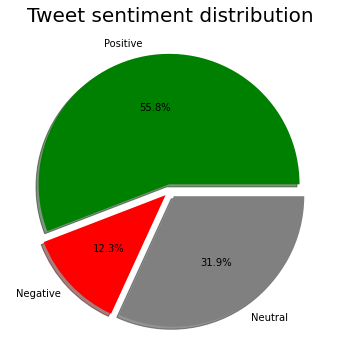

In [ ]:
print('total positive tweets: ', twitter_positive.shape[0])
print('total negative tweets: ', twitter_negative.shape[0])
print('total neutral tweets: ', twitter_neutral.shape[0])


labels = ['Positive', 'Negative', 'Neutral']
sizes = [twitter_positive.shape[0], twitter_negative.shape[0], twitter_neutral.shape[0]]
colors=['green','red','gray']
explode = (0.05, 0.05, 0.05)

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, explode=explode,colors=colors, labels=labels,
        autopct='%1.1f%%', shadow=True)

ax.set_title("Tweet sentiment distribution", fontsize=20)

plt.show()

# Wordclouds

In [ ]:
tokens = twitter['cleaned_tweet'].apply(lambda x: word_tokenize(x))
filtered_tokens = tokens.apply(lambda x: [w for w in x if not w in STOPWORDS])
flat_tokens = [item for sublist in filtered_tokens for item in sublist]
words = [w for w in flat_tokens if not w in STOPWORDS and w.isalpha()]

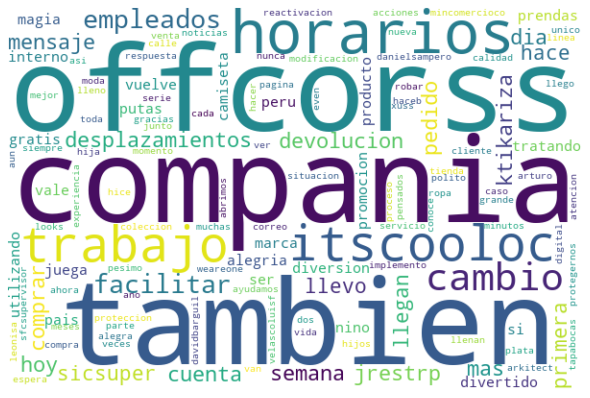

In [ ]:
#Wordcloud con sólo palabras (unigrams)
textoWC = ' '.join(words)

wordcloud = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = STOPWORDS,# max_words=200,
                relative_scaling =0, collocations=False,
                min_font_size = 10).generate(textoWC) 

plt.figure(figsize = (8, 6)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Wordclouds by sentiment

## Positive

In [ ]:
tokens_positive = twitter_positive['cleaned_tweet'].apply(lambda x: word_tokenize(x))
filtered_tokens_positive = tokens_positive.apply(lambda x: [w for w in x if not w in STOPWORDS])
flat_tokens_positive = [item for sublist in filtered_tokens_positive for item in sublist]
words_positive = [w for w in flat_tokens_positive if not w in STOPWORDS and w.isalpha()]

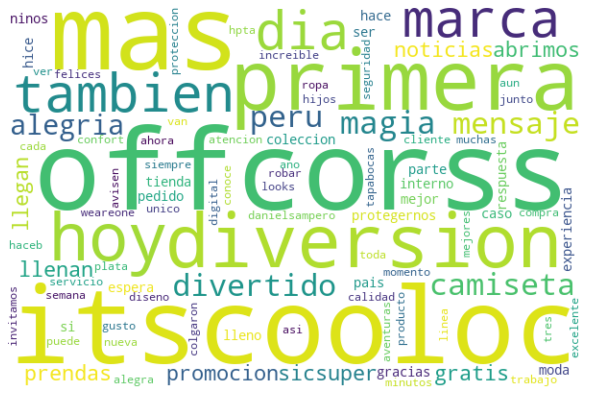

In [ ]:
#Wordcloud con sólo palabras (unigrams)
textoWC_positive = ' '.join(words_positive)

wordcloud_positive = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = STOPWORDS,# max_words=200,
                relative_scaling =0, collocations=False,
                min_font_size = 10).generate(textoWC_positive) 

plt.figure(figsize = (8, 6)) 
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Negative

In [ ]:
tokens_negative = twitter_negative['cleaned_tweet'].apply(lambda x: word_tokenize(x))
filtered_tokens_negative = tokens_negative.apply(lambda x: [w for w in x if not w in STOPWORDS])
flat_tokens_negative = [item for sublist in filtered_tokens_negative for item in sublist]
words_negative = [w for w in flat_tokens_negative if not w in STOPWORDS and w.isalpha()]

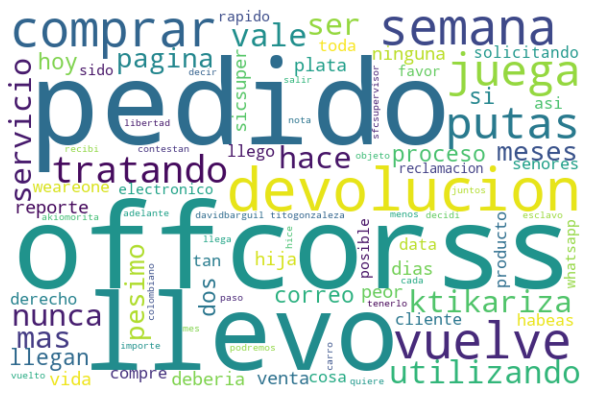

In [ ]:
#Wordcloud con sólo palabras (unigrams)
textoWC_negative = ' '.join(words_negative)

wordcloud_negative = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = STOPWORDS,# max_words=200,
                relative_scaling =0, collocations=False,
                min_font_size = 10).generate(textoWC_negative) 

plt.figure(figsize = (8, 6)) 
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Neutral

In [ ]:
tokens_neutral = twitter_neutral['cleaned_tweet'].apply(lambda x: word_tokenize(x))
filtered_tokens_neutral = tokens_neutral.apply(lambda x: [w for w in x if not w in STOPWORDS])
flat_tokens_neutral = [item for sublist in filtered_tokens_neutral for item in sublist]
words_neutral = [w for w in flat_tokens_neutral if not w in STOPWORDS and w.isalpha()]

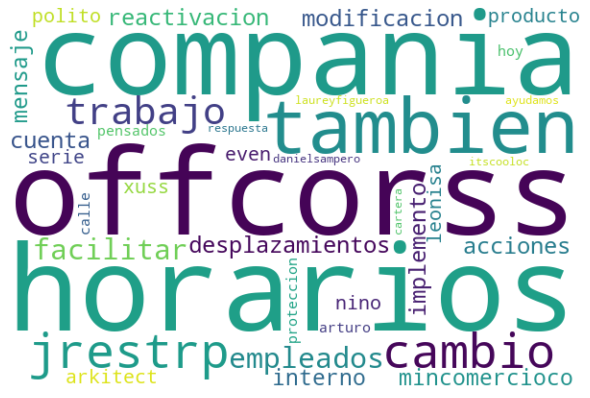

In [ ]:
#Wordcloud con sólo palabras (unigrams)
textoWC_neutral = ' '.join(words_neutral)

wordcloud_neutral = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = STOPWORDS,# max_words=200,
                relative_scaling =0, collocations=False,
                min_font_size = 10).generate(textoWC_neutral) 

plt.figure(figsize = (8, 6)) 
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# N-grams frecuency

In [ ]:
# distribucion de n-grams despues de remover stop words
def get_top_n_words(corpus, r, n=None):
    vec = CountVectorizer(ngram_range=(r, r), stop_words = STOPWORDS).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(twitter['cleaned_tweet'], 1, 20)
common_bigrams = get_top_n_words(twitter['cleaned_tweet'], 2, 20)
common_trigrams = get_top_n_words(twitter['cleaned_tweet'], 3, 20)
common_words_without_offcorss = get_top_n_words(twitter_without_offcorss['cleaned_tweet'], 1, 20)

print('Unigrams frecuency \n')
for word, freq in common_words:
    print(word, freq) 
print('')
print('Bigrams frecuency')
for word, freq in common_bigrams:
    print(word, freq) 
print('')
print('Trigrams frecuency')
for word, freq in common_trigrams:
    print(word, freq) 


Unigrams frecuency 

offcorss 2282
tambien 441
compania 404
horarios 392
trabajo 347
itscooloc 342
cambio 318
empleados 308
facilitar 308
desplazamientos 308
cuenta 308
jrestrp 295
mas 279
pedido 248
hoy 215
mensaje 178
gracias 174
comprar 168
devolucion 164
ktikariza 154

Bigrams frecuency
compania offcorss 392
offcorss cambio 308
cambio horarios 308
horarios trabajo 308
trabajo empleados 308
empleados facilitar 308
facilitar desplazamientos 308
desplazamientos tambien 308
tambien cuenta 308
jrestrp compania 295
offcorss itscooloc 242
offcorss vuelve 123
vuelve juega 123
juega llevo 123
llevo putas 123
putas semanas 123
semanas tratando 123
tratando comprar 123
comprar utilizando 123
utilizando vale 123

Trigrams frecuency
compania offcorss cambio 308
offcorss cambio horarios 308
cambio horarios trabajo 308
horarios trabajo empleados 308
trabajo empleados facilitar 308
empleados facilitar desplazamientos 308
facilitar desplazamientos tambien 308
desplazamientos tambien cuenta 308
jres

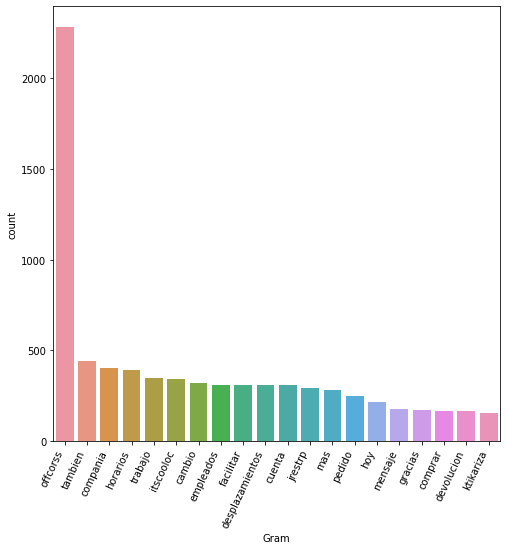

In [ ]:
unigrams = pd.DataFrame(common_words, columns = ['Gram' , 'count'])
bGraph = plt.figure(figsize=(8,8))
char = sns.barplot(x = 'Gram', y = 'count', data=unigrams)
char.set_xticklabels(labels=unigrams['Gram'], rotation=65, horizontalalignment='right')
plt.show()

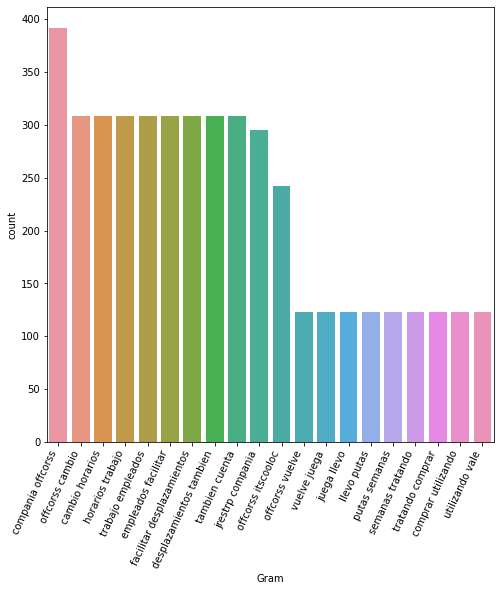

In [ ]:
bigrams = pd.DataFrame(common_bigrams, columns = ['Gram' , 'count'])
bGraph = plt.figure(figsize=(8,8))
char = sns.barplot(x = 'Gram', y = 'count', data=bigrams)
char.set_xticklabels(labels=bigrams['Gram'], rotation=65, horizontalalignment='right')
plt.show()


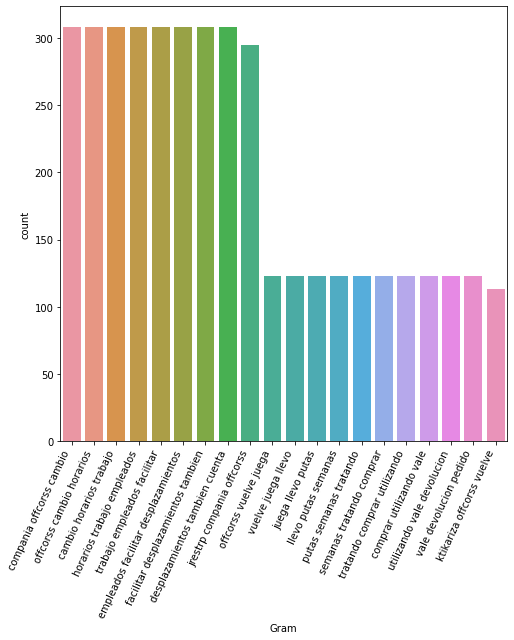

In [ ]:
trigrams = pd.DataFrame(common_trigrams, columns = ['Gram' , 'count'])
bGraph = plt.figure(figsize=(8,8))
char = sns.barplot(x = 'Gram', y = 'count', data=trigrams)
char.set_xticklabels(labels=trigrams['Gram'], rotation=65, horizontalalignment='right')
plt.show()

In [ ]:
emojis = twitter['emojis_in_tweet'].tolist()
emojis[0]

'🐨 ✨ ➤'

In [ ]:
emojis = twitter['emojis_in_tweet'].tolist()
#emojis
emoji_text = []
for i in range(len(emojis)):
  if emojis[i]:
    X = demoji.findall(emojis[i])
    emoji_text.append(X)
  else:
    emoji_text.append(None)

emoji_text[:5]


[{'✨': 'sparkles', '🐨': 'koala'},
 None,
 None,
 None,
 {'⚡': 'high voltage', '😎': 'smiling face with sunglasses'}]